## GAN model

In 2014, Ian Goodfellow and his colleagues at the University of Montreal published a stunning paper introducing the world to GANs, or generative adversarial networks. The models play two distinct (literally, adversarial) roles. Given some real data set R, G is the generator, trying to create fake data that looks just like the genuine data, while D is the discriminator, getting data from either the real set or G and labeling the difference. Goodfellow’s metaphor (and a fine one it is) was that G was like a team of forgers trying to match real paintings with their output, while D was the team of detectives trying to tell the difference. (Except that in this case, the forgers G never get to see the original data — only the judgments of D. They’re like blind forgers.)

![GAN](https://raw.githubusercontent.com/manhlab/practike-gan-2021/main/gan-mnist.png)

Here's what we're going to do:

- Define the parameters
- Load the data (with transforms and normalization)
- Denormalize for visual inspection of samples
- Define the Discriminator network, the Generator network
- Study the activation function: Leaky ReLU
- Explain the output activation function: Tanh, Sigmoid
- Look at some sample outputs
- Define losses, optimizers and helper functions for training
 - For discriminator
 -  For generator
- Train the model
- Save intermediate generated images to file
- Look at some outputs
- Save the models

![MNIST](https://i.imgur.com/CAYnuo1.jpeg)

### Define parameters & Load Dataset 

In [9]:
import torch 
import torch.nn as nn
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torchvision
from torchvision.transforms import ToTensor, Normalize, Compose
from torchvision.datasets import MNIST
from IPython.display import Image
from torchvision.utils import save_image
import os
%matplotlib inline 
plt.style.use("ggplot")
hidden_size = 256 
batch_size = 100 
LR = 0.0002
num_epochs = 300
sample_dir = "./images"
latent_size = 64 # input random input vector latent
image_size = 784 # 28*28 flatten
device = 'cuda' if torch.cuda.is_available() else 'cpu'
number_class = 10
if device == 'cuda':
  !nvidia-smi
if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)
mnist = MNIST(root='data', 
              train=True, 
              download=True,
              transform=Compose([ToTensor(), Normalize(mean=(0.5,), std=(0.5,))]))

0.6%

100.0%


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



46.1%

102.8%


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



100.0%


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



112.7%

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw




/usr/local/lib/python3.9/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Label:  5


(array([[1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        ...,
        [1., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 1.]]),
 array([-1.        , -0.86771244, -0.7354248 , -0.60313725, -0.47084966,
        -0.3385621 , -0.20627451, -0.07398693,  0.05830066,  0.19058824,
         0.32287583,  0.4551634 ,  0.587451  ,  0.71973854,  0.85202616,
         0.9843137 ], dtype=float32),
 <a list of 100 BarContainer objects>)

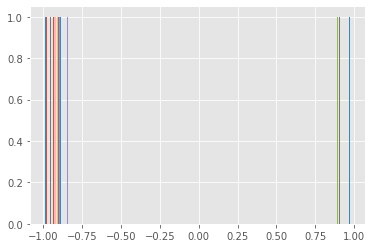

In [10]:
img, label = mnist[0]
print('Label: ', label)
plt.hist(img[:,5:15,5:15].flatten(), bins=15)

In [11]:
def denorm(x):
    out = (x + 1) / 2
    return out.clamp(0, 1)

Label: 5


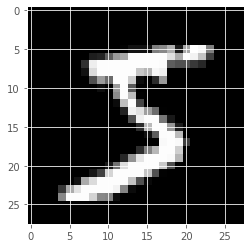

In [13]:
img_norm = denorm(img)
plt.imshow(img_norm[0], cmap='gray')
print('Label:', label)

In [23]:
from torch.utils.data import DataLoader
data_loader = DataLoader(mnist, batch_size, shuffle=True)

first batch
torch.Size([100, 1, 28, 28])
tensor([2, 3, 4, 1, 0, 3, 5, 3, 1, 1, 7, 8, 5, 7, 6, 7, 0, 5, 0, 8, 8, 6, 9, 7,
        8, 2, 1, 0, 0, 0, 6, 1, 8, 5, 4, 5, 5, 0, 6, 9, 7, 7, 2, 4, 5, 4, 8, 3,
        7, 7, 4, 4, 6, 1, 5, 5, 1, 4, 3, 8, 6, 2, 6, 0, 3, 3, 0, 3, 3, 7, 9, 3,
        9, 3, 6, 5, 9, 4, 0, 0, 7, 4, 8, 8, 0, 4, 5, 0, 0, 1, 4, 2, 5, 3, 1, 0,
        0, 9, 4, 1])


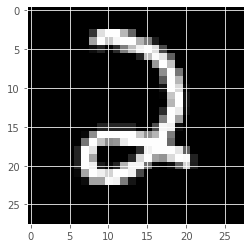

In [6]:
for img_batch, label_batch in data_loader:
    print('first batch')
    print(img_batch.shape)
    plt.imshow(img_batch[0][0], cmap='gray')
    print(label_batch)
    break

GAN состоит из двух глубоких сетей, генератора и дискриминатора. генератор создает изображения, прежде чем научиться его обучать. Поскольку дискриминатор представляет собой модель бинарной классификации, мы можем использовать функцию потери бинарной кросс-энтропии для количественной оценки того, насколько хорошо он может различать реальные и сгенерированные изображения.

![](https://raw.githubusercontent.com/manhlab/practike-gan-2021/main/04-mnist-cgan/cgan-dist.png)

In [34]:
import torch.nn.functional as F
number_class = 10
class Generator(nn.Module):
    def __init__(self, latent_size,image_size, hidden_size, number_class):
        #linear1 - relu - linear2 - relu - linear3 - tanh
        super(Generator, self).__init__()
        self.linear1 = nn.Linear(latent_size + number_class, hidden_size)
        self.linear2 = nn.Linear(hidden_size, hidden_size)
        self.linear3 = nn.Linear(hidden_size, image_size)
        self.label_embedding = nn.Embedding( number_class, number_class)
    def forward(self, x, label):
        emb = self.label_embedding(label)
        x = torch.cat([x, emb[:,-1,:]], 1)
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        x = F.tanh(self.linear3(x))
        return x

class Discriminator(nn.Module):
    def __init__(self, image_size, hidden_size, number_class):
        #linear1 - leaky_relu - linear2 - leaky_relu - linear3 - sigmoid
        super(Discriminator, self).__init__()
        self.linear1 =  nn.Linear(image_size + number_class, hidden_size)
        self.linear2 =  nn.Linear(hidden_size, hidden_size)
        self.linear3 = nn.Linear(hidden_size, 1)
        self.label_embedding = nn.Embedding(number_class, number_class)
    def forward(self, x, label):
        emb = self.label_embedding(label)
        x = torch.cat([x, emb[:,-1,:]], 1)
        x = F.leaky_relu(self.linear1(x),  negative_slope=0.2)
        x = F.leaky_relu(self.linear2(x),  negative_slope=0.2)
        x = F.sigmoid(self.linear3(x))
        return x

Почему последний слой генератор - Tanh() а дискриминатор - Sigmoid() ? tanh -1-1 , sigmoid 0-1

In [35]:
G = Generator(latent_size, image_size, hidden_size, number_class)
D = Discriminator(image_size, hidden_size, number_class)

In [36]:
y = G(torch.randn(2, latent_size), torch.LongTensor([[1], [1]]))
gen_imgs = denorm(y.reshape((-1, 28,28)).detach())

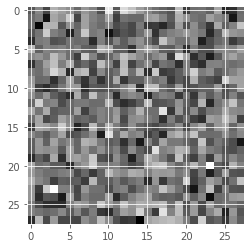

In [37]:
plt.imshow(gen_imgs[0], cmap='gray');

In [38]:
criterion = nn.BCELoss()
d_optimizer = torch.optim.Adam(D.parameters(), lr=LR)
g_optimizer = torch.optim.Adam(G.parameters(), lr=LR)

Discriminator Training

In [39]:
def reset_grad():
    d_optimizer.zero_grad()
    g_optimizer.zero_grad()

def train_discriminator(images, digit):    
    # Loss for real images
    real_labels = torch.ones(batch_size, 1).to(device)
    outputs = D(images, digit)
    d_loss_real = criterion(outputs, real_labels)
    real_score = outputs

    # Loss for fake images
    z = torch.randn(batch_size, latent_size).to(device)
    fake_labels = torch.zeros(batch_size, 1).to(device)
    fake_images = G(z, digit)
    outputs = D(fake_images, digit)
    d_loss_fake = criterion(outputs, fake_labels)
    fake_score = outputs

    # Combine losses
    d_loss = d_loss_real + d_loss_fake
    # Reset gradients
    reset_grad()
    # Compute gradients
    d_loss.backward()
    # Adjust the parameters using backprop
    d_optimizer.step()
    
    return d_loss, real_score, fake_score

Generator Training

In [40]:
def train_generator():
    # Generate fake images and calculate loss
    z = torch.Tensor(np.random.normal(0, 1, (batch_size, latent_size))).to(device)
    gens_label = torch.randint(0, 9, (batch_size,1)).to(device)
    fake_images = G(z, gens_label)
    labels = torch.ones(batch_size, 1).to(device)
    g_loss = criterion(D(fake_images, gens_label), labels)

    # Backprop and optimize
    reset_grad()
    g_loss.backward()
    g_optimizer.step()
    return g_loss, fake_images

## Start the training proccess

In [41]:
def save_fake_images(index):
    # sample_vectors = torch.randn(batch_size, latent_size).to(device)
    sample_vectors = torch.Tensor(np.random.normal(0, 1, (batch_size, latent_size))).to(device)
    gens_label = torch.randint(0, 9, (batch_size,1)).to(device)
    fake_images = G(sample_vectors, gens_label).to(device)
    fake_images = fake_images.reshape(fake_images.size(0), 1, 28, 28)
    fake_fname = 'fake_images-{0:0=4d}.png'.format(index)
    print('Saving', fake_fname)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=10)

In [47]:
%%time
total_step = len(data_loader)
d_losses, g_losses, real_scores, fake_scores = [], [], [], []
G.to(device)
D.to(device)
for epoch in range(num_epochs):
    for i, (images, digit) in enumerate(data_loader):
        # Load a batch & transform to vectors
        images = images.reshape(batch_size, -1).to(device)
        digit = torch.LongTensor(digit).view(-1, 1).to(device)
        # Train the discriminator and generator
        d_loss, real_score, fake_score = train_discriminator(images, digit)
        g_loss, fake_images = train_generator()
        
        # Inspect the losses
        if (i+1) % 200 == 0:
            d_losses.append(d_loss.item())
            g_losses.append(g_loss.item())
            real_scores.append(real_score.mean().item())
            fake_scores.append(fake_score.mean().item())
            print('Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}' 
                  .format(epoch, num_epochs, i+1, total_step, d_loss.item(), g_loss.item(), 
                          real_score.mean().item(), fake_score.mean().item()))
    # Sample and save images
    save_fake_images(epoch+1)

Epoch [0/300], Step [200/600], d_loss: 0.4273, g_loss: 4.9406, D(x): 0.85, D(G(z)): 0.07
Epoch [0/300], Step [400/600], d_loss: 0.2413, g_loss: 3.9620, D(x): 0.95, D(G(z)): 0.13
Epoch [0/300], Step [600/600], d_loss: 1.2634, g_loss: 3.8974, D(x): 0.89, D(G(z)): 0.51
Saving fake_images-0001.png
Epoch [1/300], Step [200/600], d_loss: 0.7264, g_loss: 2.1606, D(x): 0.78, D(G(z)): 0.20
Epoch [1/300], Step [400/600], d_loss: 0.3666, g_loss: 3.3381, D(x): 0.85, D(G(z)): 0.07
Epoch [1/300], Step [600/600], d_loss: 0.0519, g_loss: 4.1042, D(x): 0.99, D(G(z)): 0.04
Saving fake_images-0002.png
Epoch [2/300], Step [200/600], d_loss: 0.2883, g_loss: 4.6366, D(x): 0.96, D(G(z)): 0.19
Epoch [2/300], Step [400/600], d_loss: 0.3891, g_loss: 3.8124, D(x): 0.87, D(G(z)): 0.09
Epoch [2/300], Step [600/600], d_loss: 0.4073, g_loss: 3.1583, D(x): 0.91, D(G(z)): 0.17
Saving fake_images-0003.png
Epoch [3/300], Step [200/600], d_loss: 0.1439, g_loss: 4.1337, D(x): 0.96, D(G(z)): 0.07
Epoch [3/300], Step [400/6

KeyboardInterrupt: 

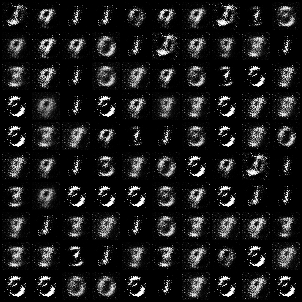

In [48]:
Image(os.path.join(sample_dir, 'fake_images-0012.png'))

In [49]:
x= torch.LongTensor([1, 1]).view(-1,1)
x.shape

torch.Size([2, 1])

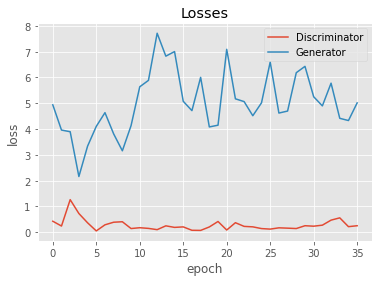

In [50]:
plt.plot(d_losses, '-')
plt.plot(g_losses, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

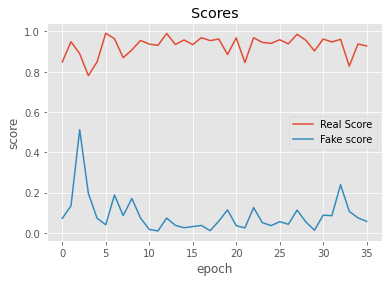

In [51]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real Score', 'Fake score'])
plt.title('Scores');